# Project: Gradients and Solvers

## Machine Learning, Winter 2017

### Name: Alex Davenport, Gherardo Morona, Yatharth Agarwal

In this project, you'll perform the following tasks:

1. [Explore gradients and contour plots](#Gradients-and-Contour-Plots),
2. [Define a `Variable` class](#The-Variable-class) which is used to compute the gradient of an "arbitrary" function,
3. [Test out your `Variable` class](#A-basic-test-of-your-Variable-class) by plotting some more gradients on contour plots, and 
4. [Build a `LogisticRegression` class](#The-LogisticRegression-class) using your `Variable` class.

In [1]:
# Standard import statements:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

plt.style.use("ggplot")

## Gradients and Contour Plots

Let's begin by understanding how contour plots work.  These are 2D representations of functions of two variables (what some people might call "3D functions").  You may be familiar with [contour maps](http://sitesmedia.s3.amazonaws.com/creekconnections/files/2014/09/topomap.jpg); a contour map is simply a contour plot of the function 

$$f(\text{lattitude}, \text{longitude}) = \left<\text{height of the Earth's surface above sea level at that point}\right>.$$ 

More generally, the contours in a plot are the paths of same height.  Thus, traveling perpendicularly to a contour means traveling "straight up or down the mountain".  Here's a first attempt at making a contour plot for a function which somewhat resembles the top of a mountain:

Exception was raised: 
TypeError: Input z must be a 2D array.


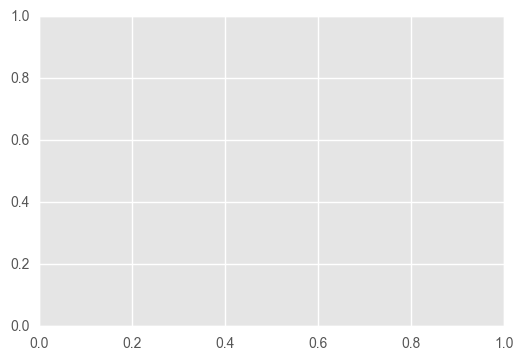

In [2]:
def f(x,y):
    return 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x

x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

# maybe a first guess is:
z = f(x,y)

try:
    plt.contour(x, y, z);
except Exception as e:
    print("Exception was raised: \n", type(e).__name__, ": ", e, sep='')

That doesn't work, because this only plugs values into $f$ which are on the *diagonal*, that is, those values in the $xy$-plane where $x=y$.  In order to make this work, we need a function value over every point in our grid, i.e. every pair of $x$- and $y$-values in the square.  This is why the value for z must be 2D, because its indices `i` and `j` are the indices of its $x$- and $y$-values of its point.  That is, `z[i,j] = f(x[i], y[j])`.

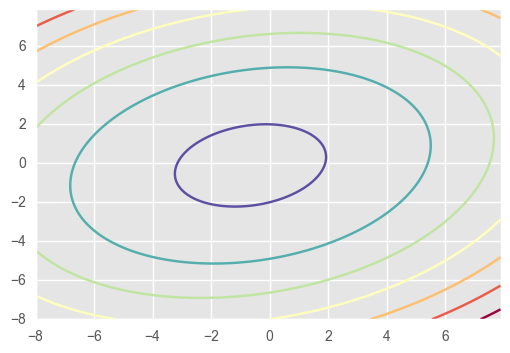

In [3]:
# Better:
z = np.array([[f(x[i],y[j]) for i in range(x.shape[0])] for j in range(y.shape[0])])
### Make sure you understand the above line!

try:
    plt.contour(x, y, z, cmap='Spectral');
except Exception as e:
    print(e)

That works, but that line defining `z` sure was a slog.  This is where the helper function `np.meshgrid` comes into play:

In [4]:
X, Y = np.meshgrid(x, y)
Z = f(X,Y)

# Convenience for printing 
iters = [('x', x), ('X', X), ('y', y), ('Y', Y), ('z', z) , ('Z', Z)]

for name, var in iters:
    print("The shape of {} is {}".format(name, var.shape))

if (z == Z).all():
    print("\nThese ways work the same")

The shape of x is (160,)
The shape of X is (160, 160)
The shape of y is (160,)
The shape of Y is (160, 160)
The shape of z is (160, 160)
The shape of Z is (160, 160)

These ways work the same


So `np.meshgrid` is used to build this `Z` (which is the same as our manually-built `z`).  But what are `X` and `Y`?

In [5]:
## Make sure you understand what the following code is doing!  It will help with understanding X and Y.

for name, var in iters[:4]:
    try:
        snipped = var[:6, :6]
    except:
        snipped = var[:6]
    print('{}:\n{}'.format(name, snipped), end='\n\n')

x:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

X:
[[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]]

y:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Y:
[[-8.  -8.  -8.  -8.  -8.  -8. ]
 [-7.9 -7.9 -7.9 -7.9 -7.9 -7.9]
 [-7.8 -7.8 -7.8 -7.8 -7.8 -7.8]
 [-7.7 -7.7 -7.7 -7.7 -7.7 -7.7]
 [-7.6 -7.6 -7.6 -7.6 -7.6 -7.6]
 [-7.5 -7.5 -7.5 -7.5 -7.5 -7.5]]



<div style="background-color: #EFDDFF; ">
<p>Describe what you're seeing:</p>
</div>

`np.meshgrid` took vector arguments x and y and returned matrices X and Y. X has as many rows as y has items, and each row is simply x. Likewise, Y has as many columns as x has items, and each column is simply y. Thus, the matrix product XY contains a pairwise product of each item of x with each item of y.

Okay, so now that we know how to plot contour plots of functions of 2 variables, let's explore adding some **gradients** to the plot.  First, a helper function, taken from earlier notes from out class.

In [6]:
def draw_arrow(a, b, c, d, ax=None):
    """ Draw an arrow on a plot.
    
    params:
        a, b -- coordinates of the base of the arrow
        c, d -- vector corresponding to the arrow (starting at the origin)
        ax   -- the matplotlib Axes object on which to draw the arrow.  If none, set to current Axes object.
    """
    ax = ax or plt.gca()
    v_0 = np.array([a,b])
    v_1 = np.array([c,d]) + v_0
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='k')
    plt.annotate('', v_1, v_0, arrowprops=arrowprops)

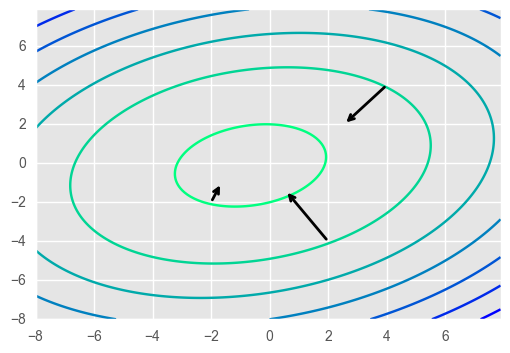

In [7]:
# Plot the contour plot as well as some gradient vectors
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

X, Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.contour(x, y, Z, cmap='winter')

# Draw some gradients
draw_arrow(2, -4, -1.45,  2.6)
draw_arrow(-2, -2, 0.35, 1)
draw_arrow(4, 4, -1.45, -2)

<div style="background-color: #EFDDFF; ">
<p> Okay, so now here's your task. The gradient of this function is $\nabla f(x,y) = \left<-.4 x^2 + .1 y - .25, -.6 y + .1 x\right>$.  Create a function `draw_gradient` that, given a point $(x,y)$, draws the gradient of $f$ at that point.  Then, recreate the plot above so that your `draw_gradient` method gets called for a handful of randomly-generated points (so that you can rerun the cell and get a new handful of points each time).  You may decide to change your contour plot to a `contourf` plot, which would fill the lines in with a solid shape.</p>
</div>

Point (6.416958872278604, -6.419900339014179) has gradient of size 17.69308601010883
Point (6.493028054353228, -4.362852787597554) has gradient of size 17.605826720758785
Point (7.101821701309865, 1.9847977899657074) has gradient of size 19.981651681438176
Point (6.614733048590454, -0.42847530104704745) has gradient of size 17.5687540769087
Point (4.414506188238976, 1.660156564543012) has gradient of size 7.64926521408077


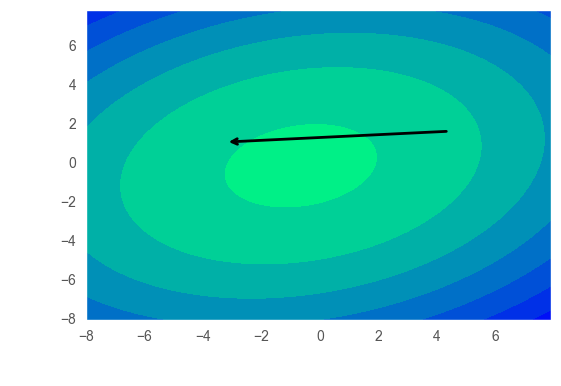

In [8]:
import random

def gradient(x, y):
    return -0.4*x**2 + 0.1*y, -0.6*y + 0.1*x

def size(x, y):
    return (x**2 + y**2)**0.5

def draw_gradient(x, y):
    draw_arrow(x, y, *gradient(x, y))

plt.contourf(x, y, Z, cmap='winter')

for _ in range(5):
    point = random.uniform(-8, 8), random.uniform(-8, 8)
    print("Point {} has gradient of size {}".format(point, size(*gradient(*point))))
    draw_gradient(*point)

<div style="background-color: #EFDFDF; ">

<h3> Rules for Gradients:</h3>

<p>In a multivariable calculus class, you would study and possibly even prove these statements.  For us, we'll take them as our programming requirements.  **Do not feel like you need to memorize these for my class. I will never ask you to compute the gradient of a function by hand on a test.**</p>

<ul>
<li> If $x_i$ is the $i^{\text{th}}$ independent variable, then $\nabla x_i = \left<0,\ldots,0,1,0,\ldots, 0\right>$, where the $1$ is in the $i^{\text{th}}$ slot.</li>
<li> The gradient is **linear**: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w_1+w_2$, then $\nabla f = \nabla w_1 + \nabla w_2$, and </li>
 <li> If $f(x_1, \ldots, x_p) = c \cdot w$, then $\nabla f = c \cdot \nabla w$.</li>
 <li> (As an extension of the first point: if $f(x_1, \ldots, x_p) = \sum_{i=1}^n w_i$, then $\nabla f = \sum_{i=1}^n\nabla w_i$.)</li>
 </ul>
<li> The gradient has a **power rule**: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w^n$ then $\nabla f = n w^{n-1} \cdot \nabla w$, </li>
 </ul>
<li> The gradient has a **product rule**: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w_1\cdot w_2$ then $\nabla f = w_1 \cdot \nabla w_2 + w_2 \cdot \nabla w_1$,</li>
 </ul>
<li> The gradient does have a *difference rule* and a *quotient rule*, but you can just define yours using the facts that $w_1 - w_2 = w_1 + (-1) \cdot w_2$ and $\dfrac{w_1}{w_2} = w_1 \cdot (w_2)^{-1}$, respectively.</li>
<li> The gradient has a **chain rule**, which manifests itself in the following ways (the only ones we'll need):</li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = \exp(w)$ then $\nabla f = \exp(w) \cdot \nabla w$,</li>
 <li> If $f(x_1, \ldots, x_p) = \ln(w)$ then $\nabla f = \frac{1}{w} \cdot \nabla w$, </li>
 <li> There are lots of others, but I don't think we'll need them for now. </li>
 </ul>
</ul>
 
 </div>

## The `Variable` class

Your main task in the project is to make a `Variable` class.  The `Variable` class is a node in the computational graph.  It should have the following attributes and methods:

* a class attribute `wengert` which is a list that keeps track of all the Variable objects in the order of a Wengert list.  There are fancy technical definitions and requirements of such a list, but for you, it should just be a list that holds all your `Variable` objects (so in the constructor, you should append `self` to the list).  You may get less milage out of this list than I did, depending on your implimentation, but I found it helpful to have it.
 * a class method which resets the wengert list to an empty list.  This allows you to redefine the expression if you mess up. Google `@staticmethod` to see the notation.
* an attribute `inputs`, a list that records which inputs the current `Variable` objects takes.  This could highly leverage your wengert list.
* an `__init__` method,
* an `eval_` method that allows you to evaluate the variable at a given value of the primitive variables,
* a `grad` method that will compute return the gradient at a given value,
* appropriate methods/functionality to calculate the gradients and function evaluation for all the gradients defined above:

As an example, if I were to say:

```
>>> x = Variable()
>>> y = Variable()
>>> z = x + y
```

This will create a new `Variable` class for `z`, and initialize it appropriately, and give it the ability to take its gradient.  The way we can implement this is by defining a *magic* method called `__add__`.  Magic methods in Python are what give it such a great functional API.  Here's an example `__add__` method, based on how I set up my constructor.  Yours might be a little bit different:

```
    def __add__(self, other):
        """ Defines the functionality of the `+` operator. """
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(inputs=[self],
                            eval_=lambda *values: other + self.eval_(*values), 
                            grad= self.grad)
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(inputs=[self, other],
                            eval_=lambda *values: self.eval_(*values) + other.eval_(*values),
                            grad= lambda *values: self.grad(*values) + other.grad(*values))
        else:
            return NotImplemented
```

See [this link](http://www.diveintopython3.net/special-method-names.html#acts-like-number) to learn about the magic methods you will need to implement.

The theory here is that you create the "ugly" `x.add(y)`-ish code once and only once, and then when you use the code later it's much more readable: `x + y`.  You'll need to do something like this for all the operations discussed above in the [gradients section](#-Rules-for-Gradients:).  The exception is for functions like `exp` and `log` (and if I wanted you to do other things, like `sin`, `cos`, `tan`, etc.).  Those will need to be class methods.  They should still return a new `Variable` object.  See below for the API that they should support.

Other methods you need to implement:

* While you do need to have an `eval_` method, if you also implement the `__call__` method (to just call `eval_`) then you can replace code of the form `w.eval_(4, 2, 8.5)` with `w(4, 2, 8.5)`, which is both cleaner and looks like function notation (which is desirable because the `w`'s really can be thought of as functions of the independent variables).
* You should implement the `__repr__` method so that you can print out your variables.  It would be especially nice if printing out a `Variable` object gave you a graph traversal of its `inputs`, similar to the `DecisionTree` class that you made before break.  It's okay here if it looks like a tree, *i.e.* nodes get repeated.  It would be a bit too much work to make the true graph visual happen, I think.
* You should implement methods like `__radd__` and `__rmul__` that give your `__add__` and `__mul__` method more functionality.  You shouldn't implement in-place methods like `__iadd__` and `__imul__`, becuase you need to be getting a new `Variable` each time and so *shouldn't* be overriding previous ones.  In fact, virtual bonus points for implementing them to raise a `NotImplementedError`. 

Here are some resources that may help you along the way:
* A good explanation on [Automatic Differentiation](https://pdfs.semanticscholar.org/be3d/17df872d41465dabda2fc9a9a61394658a1a.pdf) (the name of this process).  It's probably much more information than you need.
* There's always [Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation).
* Another take on [operator overloading in Python](http://blog.teamtreehouse.com/operator-overloading-python).

## A "complete" collection of uses that demonstrates the API 

```
>>> from Variable import exp, log
>>> x_1 = Variable()
>>> x_2 = Variable()
>>> x_3 = Variable()
>>> z = exp(x_1 + x_2**2) + 3 * log(27 - x_1 * x_2 * x_3)
>>> # Evaluate the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z(3, 1, 7)
<whatever that's equal to>
>>> # Determine the gradient of the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z.grad(3, 1, 7)
<whatever that's equal to>
>>> print(z)
<somewhat attractive, readable printout of the computational graph>
```

## Some thoughts on coding process

* I recommend that you don't actually define the class in a single cell in this notebook.  It's going to get a bit big, and it's going to be difficult to work on it together if it's in a cell on a jupyter notebook.  I believe that a better strategy for designing this class is to have a Python file `variable.py` that contains your `Variable` class, and then just have a cell like this:

In [9]:
from symdiff import *

In [10]:
import sys
from importlib import reload
reload(sys.modules['symdiff'])
from symdiff import *

* Then, when you change something and want to check out how it works, just rerun the above cell.
* This also makes sharing code via something like github a lot easier!
* I highly recommend you begin by making everything other than gradients work, and then add gradients afterward.

In [11]:
# Put whatever test code you want here.  I'm curious to see how you tested it 
# out, so the rest of this section won't be graded in the usual "no long printouts", 
# grumbly ol' Dr. Z kind of way (though do let me know what you're attempting to do, 
# and whether it's working!)

In [12]:
import doctest

import symdiff_test

doctest.testmod(symdiff_test)

TestResults(failed=0, attempted=32)

## A basic test of your `Variable` class

Going back up to the contour plots above, create a single cell that defines a random 2-dimensional polynomial in the same form as $f$ above (or to make it more interesting, add higher powers of $x$ and $y$), and then computes its gradient, and plots several randomly chosen gradient vectors.  Remember, gradients should always be pointing "up the mountain", and should be parallel to the contours of your function.

In [13]:
def random_polynomial(*, max_vars, max_pow, min_coef, max_coef):
    vars_ = [Var('x' + str(i)) for i in range(max_vars)]
    return Function(simplify(
        sum(
            sum(
                random.uniform(min_coef, max_coef) * var ** pow_
                for pow_ in range(max_pow + 1))
            for var in vars_
        )
    ), *vars_)

def random_point(min_, max_):
    return random.uniform(min_, max_), random.uniform(min_, max_)

def plot_contour(f, min_, max_, delta=0.1):
    x = np.arange(min_, max_, delta)
    y = np.arange(min_, max_, delta)

    X, Y = np.meshgrid(x,y)
    Z = poly(X,Y)

    plt.contourf(x, y, Z, cmap='winter')

In [14]:
MIN, MAX = -10.0, 10.0
poly = random_polynomial(max_vars=2, max_pow=3, min_coef=-0.05, max_coef=0.05)
grad = gradient(poly)
print(poly)
print(grad)

Function((-0.019421037878114344 + (0.030709878888866685 * x0) + (-0.019087282965033748 * (x0 ** 2)) + (0.02815648080817308 * (x0 ** 3)) + (0.0016635724135371718 * x1) + (-0.031905381225993124 * (x1 ** 2)) + (0.04969249690040327 * (x1 ** 3))), x0, x1)
[Function((0.030709878888866685 + (-0.038174565930067496 * x0) + (0.08446944242451924 * (x0 ** 2))), x0, x1), Function((0.0016635724135371718 + (-0.06381076245198625 * x1) + (0.1490774907012098 * (x1 ** 2))), x0, x1)]


Point (8, 6) with gradient size 6
Point (-2, 5) with gradient size 3
Point (-7, -0) with gradient size 5
Point (8, 7) with gradient size 9
Point (-10, -6) with gradient size 10


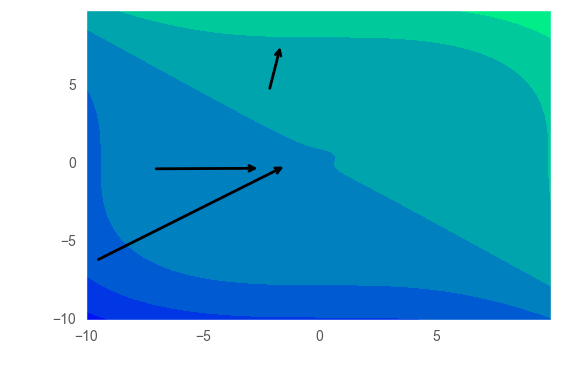

In [15]:
plot_contour(poly, MIN, MAX)
for i in range(5):
    point = random_point(MIN, MAX)
    grad_value = [evaluate(comp, *point) for comp in grad]
    print("Point ({:.0f}, {:.0f}) with gradient size {:.0f}".format(*point, size(*grad_value)))
    draw_arrow(*point, *grad_value)

## The `LogisticRegression` class

Now that you have the class needed for creating a gradient, it's time to put it to use.  Construct a `LogisticRegression` class that serves as a logistic regression model.  It should support the standard Scikit-Learn API:

```
>>> X,y = <some dataset consisting numpy arrays in the standard form>
>>> model = LogisticRegression()
>>> model.fit(X, y)
>>> X_test, y_true = <some test dataset in the standard form>
>>> y_preds = model.predict(X_test)
>>> from sklearn.metrics import accuracy_score
>>> accuracy_score(y_true, y_preds)
```

Use your `Variable` class in the `fit` method of your class (or wherever else seems appropriate).  Remember, you're taking the gradient of the cost function, and the cost function has as its inputs the parameters of your model.  So you should have a `Variable` for every model parameter.  You **don't** need to support multi-class predictions (as in, you can assume your output variable `y` is binary), but you **do** need to support a multidimensional `X` (as in, perhaps my dataset has 7 predictors/features, I want to be able to use your class to fit my data).

**Note**: I recognize that you could just take the partial derivative (or google it), but that's not the point of this project!  The goal is to struggle through both creating and using your `Variable` class.

In [16]:
from logistic_reg import LogisticRegression
import sys
from importlib import reload
reload(sys.modules['logistic_reg'])
from logistic_reg import LogisticRegression

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

TEST_SIZE = 0.2

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.loc[:, 4] = df.loc[:, 4].apply(lambda x : 1 if x == "Iris-setosa" else 0)

train, test = train_test_split(df, test_size=TEST_SIZE)

train_X = train[[0, 1, 2, 3]].values
train_y = train[[4]].values.T[0]
test_X = test[[0, 1, 2, 3]].as_matrix()
test_y = test[[4]].values.T[0]

In [18]:
model = LogisticRegression(learning_rate=0.5, iterations=15)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

In [19]:
print("Accuracy of {}%".format(int(100 * accuracy_score(test_y, pred_y))))
# The value of 100% is not a mistake! Try setting TEST_SIZE to 0.99 and run this again. You'll get accuracies below 50%.

Accuracy of 100%


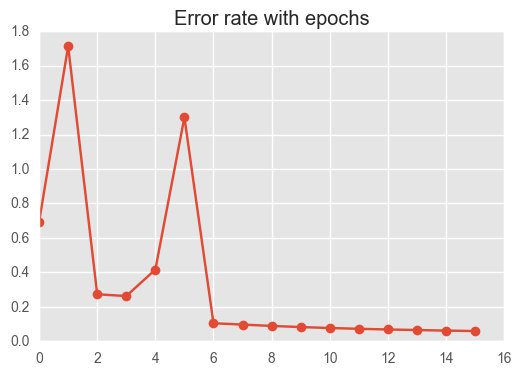

In [20]:
plt.plot(range(len(model.errors)), model.errors, '-o')
plt.title("Error rate with epochs")
plt.show()

### Too Low Learning Rate

Accuracy of 56%


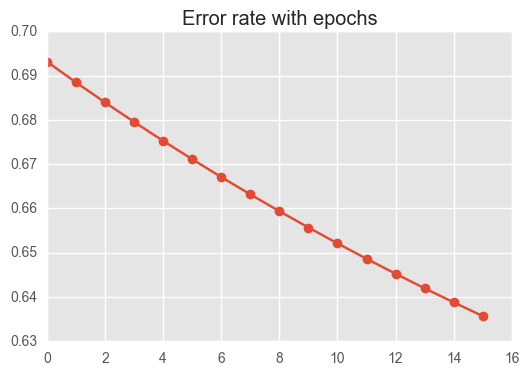

In [21]:
model = LogisticRegression(learning_rate=0.001, iterations=15)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
print("Accuracy of {}%".format(int(100 * accuracy_score(test_y, pred_y))))
plt.plot(range(len(model.errors)), model.errors, '-o')
plt.title("Error rate with epochs")
plt.show()

### Too High Learning Rate

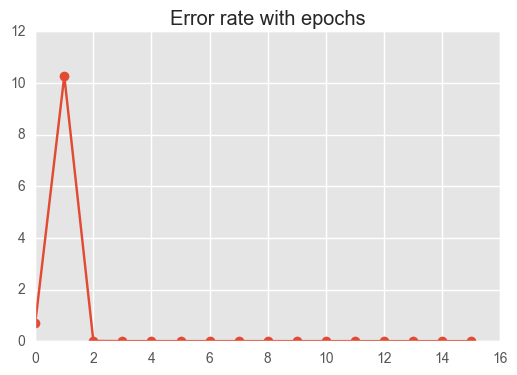

In [22]:
model = LogisticRegression(learning_rate=3, iterations=15)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
plt.plot(range(len(model.errors)), model.errors, '-o')
plt.title("Error rate with epochs")
plt.show()